### Task 2: Identify annual salary and predict annual salary using Regression and Decision Tree

#### install libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

#### load data

In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_excel('ANZ synthesised transaction dataset.xlsx')

#### Inspect data

In [ ]:
# check data types
data.info()

# check unique values per feature
data.nunique()

# create a subset related to salary
salary = data[data.txn_description=='PAY/SALARY']

# check for missing values
salary.isna().sum()

# check the relationship between account and customer_id
accountCustomerID = salary.account.groupby(salary.customer_id).describe()
accountCustomerID[accountCustomerID.iloc[:, 1] > 1].sum()

# check the relationship between long_lat and customer_id
locationCustomerID = salary.long_lat.groupby(salary.customer_id).describe()
locationCustomerID[locationCustomerID.iloc[:, 1] > 1].sum()


result shows that: <br>
- 5 columns are with only missing values:  <br>
      *  ['card_present_flag', 'merchant_id', 'merchant_suburb', 'merchant_state', 'merchant_long_lat'] 
- 7 columns have only 1 unique value, not useful for prediction:  <br>
      *   ['status', 'bpay_biller_code', 'currency', 'txn_description', 'merchant_code', 'country', 'movement']
- 'account' and 'customer_id' are pointing to the same customer, keep 1 remove 1
- each 'customer_id' has one unique location 'long_lat'

In [20]:
# remove irrelevant data
salary.drop(axis=1, columns=['card_present_flag', 'merchant_id', 'merchant_suburb', 'merchant_state', 'merchant_long_lat'], inplace=True)
salary.drop(axis=1, columns=['status', 'bpay_biller_code', 'currency', 'txn_description', 'merchant_code', 'country', 'movement'], inplace=True)
salary.drop(axis=1, columns='account', inplace=True)

status                1
bpay_biller_code      1
account             100
currency              1
long_lat            100
txn_description       1
merchant_code         1
first_name           80
balance             883
date                 65
gender                2
age                  33
extraction          394
amount              100
transaction_id      883
country               1
customer_id         100
movement              1
dtype: int64

In [ ]:
# check for duplicates -> 0
salary.duplicated().sum()

In [59]:
# split 'long_lat' into two separate columns and change the datatype to float
salary[['long', 'lat']] = salary.long_lat.str.split(expand=True)
salary[['long', 'lat']] = salary[['long', 'lat']].astype('float')

#### identify annual salary

In [52]:
# calculate annual salary: take the mean of the salaries from the 3 given month, and multiply 12
annualSalary = salary.amount.groupby(salary.customer_id).sum()
annualSalary = round(annualSalary/3*12,2)
# create a dataset to store the salary
annualSalary = annualSalary.reset_index()

#### create subsets to store each unique 'txn_description' 

In [161]:
test = data.amount.groupby([data.customer_id, data.txn_description]).sum().to_frame().reset_index()
payment = test[['customer_id', 'amount']][test.txn_description=='PAYMENT']
pos = test[['customer_id', 'amount']][test.txn_description=='POS']
sales_pos = test[['customer_id', 'amount']][test.txn_description=='SALES-POS']
inter_bank = test[['customer_id', 'amount']][test.txn_description=='INTER BANK']
phone_bank = test[['customer_id', 'amount']][test.txn_description=='PHONE BANK']
pay = test[['customer_id', 'amount']][test.txn_description=='PAY/SALARY']


#### merge all subsets created previously

In [189]:
dataMerge = salary[['customer_id', 'gender', 'age', 'long', 'lat']]
dataMerge.drop_duplicates(inplace=True)
dataMerge['gender'].replace({'F': 0, 'M': 1}, inplace=True)


txn_unique = [payment, pos, sales_pos, inter_bank, phone_bank, pay]
for i in txn_unique:
    dataMerge = pd.merge(dataMerge, i, how='left', on='customer_id')
dataMerge = pd.merge(dataMerge, annualSalary, on='customer_id')

dataMerge.columns = ['customer_id', 
                     'gender', 
                     'age', 
                     'long', 
                     'lat',  
                     'payment', 
                     'pos', 
                     'sales_pos', 
                     'inter_bank', 
                     'phone_bank',
                     'monthly_salary',
                     'annual_salary']

dataMerge['monthly_salary'] = round(dataMerge['monthly_salary'] / 3, 2)

In [190]:
# fill NaN values 
dataMerge.fillna(0, inplace=True)

#### correlations

<AxesSubplot:>

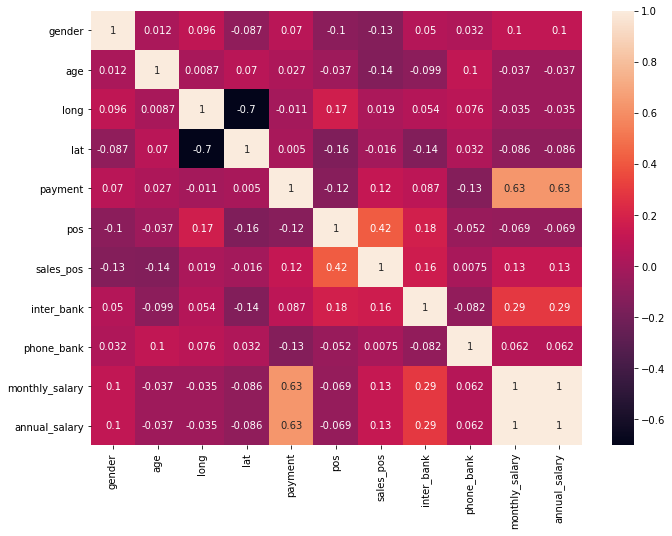

In [191]:
# visualize correlations
plt.figure(figsize=(11,8))
sns.heatmap(dataMerge.corr(), annot=True)

the heatmap shows that:
- Annual salary is highly correlated with monthly salary and payment.
- There is a weak correlation between annual salary and inter bank. 
- The relationships between annual salary and the rest of the features are closer to 0. 

#### split data

In [192]:
X = dataMerge.iloc[:80, 1:-1]
X_test = dataMerge.iloc[80:, 1:-1]
Y = np.array(dataMerge.iloc[:80, -1]).reshape(-1, 1)
Y_test = np.array(dataMerge.iloc[80:, -1]).reshape(-1, 1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Initialize LinearRegression model & make predictions

In [267]:
# monthly_salary and payment are highly correlated with annual_salary, thus use only them for prediction
data_Merge = dataMerge[['customer_id', 'payment', 'monthly_salary', 'annual_salary']]

# split train, validation, test data
X2 = data_Merge.iloc[:80, 1:-1]
X2_test = data_Merge.iloc[80:, 1:-1]
Y2 = np.array(data_Merge.iloc[:80, -1]).reshape(-1, 1)
Y2_test = np.array(data_Merge.iloc[80:, -1]).reshape(-1, 1)

X2_train, X2_val, Y2_train, Y2_val = train_test_split(X2, Y2, test_size=0.2, random_state=42)

# initialize model
regressor = LinearRegression()

# fit data
regressor.fit(X2_train, Y2_train)

# predict 
yTrain_pred2 = regressor.predict(X2_train)
yVal_pred2 = regressor.predict(X2_val)
yTest_pred2 = regressor.predict(X2_test)

#### model evaluation

In [268]:
# Train set
MSE_tn = round(mean_squared_error(Y2_train, yTrain_pred2), 3)
RMSE_tn = round(np.sqrt(mean_squared_error(Y2_train, yTrain_pred2)), 3)
MAE_tn = round(mean_absolute_error(Y2_train, yTrain_pred2), 3)
R_squared_tn = round(r2_score(Y2_train, yTrain_pred2), 3)

# val set
MSE_val = round(mean_squared_error(Y2_val, yVal_pred2), 3)
RMSE_val = round(np.sqrt(mean_squared_error(Y2_val, yVal_pred2)), 3)
MAE_val = round(mean_absolute_error(Y2_val, yVal_pred2), 3)
R_squared_val = round(r2_score(Y2_val, yVal_pred2), 3)

# Test set
MSE_tt = round(mean_squared_error(Y2_test, yTest_pred2), 3)
RMSE_tt = round(np.sqrt(mean_squared_error(Y2_test, yTest_pred2)), 3)
MAE_tt = round(mean_absolute_error(Y2_test, yTest_pred2), 3)
R_squared_tt = round(r2_score(Y2_test, yTest_pred2), 3)

results2 = pd.DataFrame({
    'Train': [MSE_tn, RMSE_tn, MAE_tn, R_squared_tn], 
    'Val': [MSE_val, RMSE_val, MAE_val, R_squared_val], 
    'Test': [MSE_tt, RMSE_tt, MAE_tt, R_squared_tt]
}, index = ['MSE', 'RMSE', 'MAE', 'R^2'])

results2

,Train,Val,Test
MSE,0.001,0.001,0.000
RMSE,0.027,0.032,0.021
MAE,0.021,0.026,0.013
R^2,1.000,1.000,1.000


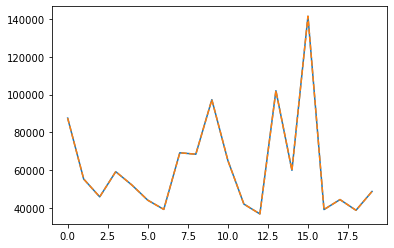

In [289]:
plt.plot(Y_test)
plt.plot(yTest_pred2,'--')

I used 4 metrics to evaluate the performance of the mdoel, and the results show that the model performs really well on all three sets. Based on the result, I would recommand using this model for customer segmentation. However, the dataset is relatively small with only 100 customers. Therefore, I would also recommand to update the model with bigger dataset and evaluate its performance. 

#### Initialize Decision Tree and make prediction

In [282]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X2_train, Y2_train)
yTrain_pred3 = dt.predict(X2_train)
yVal_pred3 = dt.predict(X2_val)
yTest_pred3 = dt.predict(X2_test)

#### model evaluation

In [283]:
# Train set
MSE_tn = round(mean_squared_error(Y2_train, yTrain_pred3), 3)
RMSE_tn = round(np.sqrt(mean_squared_error(Y2_train, yTrain_pred3)), 3)
MAE_tn = round(mean_absolute_error(Y2_train, yTrain_pred3), 3)
R_squared_tn = round(r2_score(Y2_train, yTrain_pred3), 3)

# val set
MSE_val = round(mean_squared_error(Y2_val, yVal_pred3), 3)
RMSE_val = round(np.sqrt(mean_squared_error(Y2_val, yVal_pred3)), 3)
MAE_val = round(mean_absolute_error(Y2_val, yVal_pred3), 3)
R_squared_val = round(r2_score(Y2_val, yVal_pred3), 3)

# Test set
MSE_tt = round(mean_squared_error(Y2_test, yTest_pred3), 3)
RMSE_tt = round(np.sqrt(mean_squared_error(Y2_test, yTest_pred3)), 3)
MAE_tt = round(mean_absolute_error(Y2_test, yTest_pred3), 3)
R_squared_tt = round(r2_score(Y2_test, yTest_pred3), 3)

results3 = pd.DataFrame({
    'Train': [MSE_tn, RMSE_tn, MAE_tn, R_squared_tn], 
    'Val': [MSE_val, RMSE_val, MAE_val, R_squared_val], 
    'Test': [MSE_tt, RMSE_tt, MAE_tt, R_squared_tt]
}, index = ['MSE', 'RMSE', 'MAE', 'R^2'])

results3

,Train,Val,Test
MSE,0.0,6287033.519,4485102.956
RMSE,0.0,2507.396,2117.806
MAE,0.0,1634.248,891.544
R^2,1.0,0.993,0.993


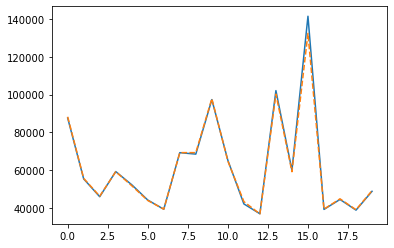

In [290]:
plt.plot(Y_test)
plt.plot(yTest_pred3, '--')

When compared to the linear regression model, the prediction of the decision tree is not ideal. <br>
However, when plotting the true salary and predicted salary, we can see that the decision tree predicts well overall, except the prediction for the peak.